In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

## 1. Dice 相似度係數（Dice Similarity Coefficient, DSC）
目的：衡量 final_mask 和 prediction 的相似程度，表示模型輸出與穩定區域的匹配度。

公式：
$$
DSC = \frac{2 \times |final\_mask \cap prediction|}{|final\_mask| + |prediction|}
$$

解釋：

- 若 DSC 接近 1，代表 final_mask 與 prediction 非常一致，表示模型對於「穩定識別區域」的預測很好。
- 若 DSC 低於 0.5，表示模型的輸出與可解釋性結果相差較大，可能不夠穩定或過度依賴某些特徵。

Final Mask: (3840, 2160)
Prediction: (3840, 2160)


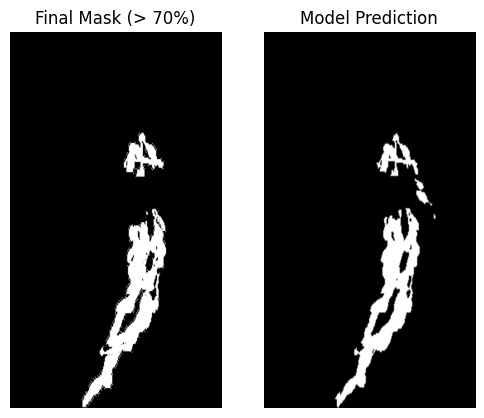

In [16]:
final_mask = cv2.imread('xai_results/final_mask.png', cv2.IMREAD_GRAYSCALE)
prediction = cv2.imread('results/prediction_1.png', cv2.IMREAD_GRAYSCALE)

print(f'Final Mask: {final_mask.shape}')
print(f'Prediction: {prediction.shape}')

fig, ax = plt.subplots(1, 2, figsize=(6, 6))
ax[0].imshow(final_mask, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Final Mask (> 70%)')

ax[1].imshow(prediction, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Model Prediction')
plt.show()

In [3]:
final_mask = (final_mask > 0).astype(np.uint8)
prediction = (prediction > 0).astype(np.uint8)

# 計算交集與並集
intersection = np.sum(final_mask * prediction)
sum_mask = np.sum(final_mask) + np.sum(prediction)

# 計算 Dice 相似度
dice_score = (2 * intersection) / sum_mask if sum_mask > 0 else 0
print(f"Dice Similarity Score: {dice_score:.4f}")

Dice Similarity Score: 0.9285


# 2. 遮蔽區域影響指標（Masking Impact Score, MIS）
目的：評估模型的輸出是否容易受到遮蔽影響。

公式：
$$
MIS = 1 - \frac{\sum_{i=1}^{N} IoU(O, O_i)}{N}
$$

解釋：
- **當模型受遮蔽影響較小：**
    - \(O_i\) 與 \(O\) 的輸出差異不大，IoU 高，MIS 低。
    - 代表模型在不同遮蔽條件下仍然能夠穩定預測。

- **當模型受遮蔽影響較大：**
    - \(O_i\) 與 \(O\) 差異大，IoU 低，MIS 高。
    - 代表模型對某些區域依賴性過高，導致輸入被遮蔽時結果變化劇烈。

In [11]:
def iou(mask1, mask2):
    """ 計算 IoU """
    intersection = np.sum((mask1 > 0) & (mask2 > 0))
    union = np.sum((mask1 > 0) | (mask2 > 0))
    return intersection / union if union > 0 else 0

# 讀取原始輸出
O = cv2.imread('results/prediction_1.png', cv2.IMREAD_GRAYSCALE)
O = (O > 0).astype(np.uint8)  # 二值化處理

prediction_files = os.listdir('xai_results/predictions')
N = len(prediction_files)  # 遮蔽測試次數

for filename in prediction_files:
    # 讀取第 i 次遮蔽後的模型輸出
    O_i = cv2.imread(f'xai_results/predictions/{filename}', cv2.IMREAD_GRAYSCALE)
    O_i = (O_i > 0).astype(np.uint8)  # 二值化處理

    # 計算 IoU
    iou_score = iou(O, O_i)
    iou_scores.append(iou_score)
    # break

# 計算 MIS
MIS = 1 - (sum(iou_scores) / N)
print(f"Masking Impact Score (MIS): {MIS:.4f}")


Masking Impact Score (MIS): 0.2755
